In [5]:
pip install bayesian-optimization

In [7]:
pip install -U libpysal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.0 MB/s eta 0:00:00


In [8]:
# **1. Import Libraries**

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd
import libpysal
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

In [13]:
# **2. Load and Clean the Data**

# Load the dataset
df = pd.read_csv('data_x.csv')

# Handle missing values
df.dropna(inplace=True)

# Convert zip_code to integer
df['zip_code'] = df['zip_code'].astype(int)

# Forward-fill missing key columns
key_cols = ['Median Estimated Home Value(owner occupied units)', 'Median Household Income', 'Median Gross Rent']
for col in key_cols:
    df[col] = df.groupby('zip_code')[col].ffill().bfill()

# Rename columns
rename_dict = {
    'Tract_number': 'tract_num',
    'Year': 'year',
    'Unweighted Sample Count of the population': 'sample_count',
    'Avg household size of occupied housing units': 'avg_hh_size',
    'Median Estimated Home Value(owner occupied units)': 'med_home_value',
    'Median Household Income': 'median_household_inc',
    'Median Gross Rent': 'median_gross_rent'
}
df.rename(columns=rename_dict, inplace=True)

# Label encode the 'state' column
df['state_label_encoded'] = LabelEncoder().fit_transform(df['state'])
df.drop(['state'], axis=1, inplace=True)

# Filter out invalid data
df = df[(df['med_home_value'] > 0) & (df['median_household_inc'] > 0)]
df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

# Document assumptions
assumptions = """
Assumptions:
1. Missing values are forward and backward filled within ZIP codes.
2. Median home values, income, and rent with 0 or negative values are considered invalid.
3. Data is aggregated at the ZIP code and year level.
4. No spatial dependency was initially considered, added in the final section.


"""
print(assumptions)


Assumptions:
1. Missing values are forward and backward filled within ZIP codes.
2. Median home values, income, and rent with 0 or negative values are considered invalid.
3. Data is aggregated at the ZIP code and year level.
4. No spatial dependency was initially considered, added in the final section.
5. The above independant features were selected only after considering the Feature importance of Random Forest Algorithm



In [42]:
# Document notes:
Notes = """
Notes:
1. The above independant features were selected only after considering the Feature importance plot of Random Forest Algorithm.
2. The final spatial dependency is done considering an external data source which will be attached in the zip file. Tiger/Lines dataset (zipcode level).
3. Multiple ML models were initially considered for median house value prediction, but Random forest was selected as the final model considering the low RSME score.
4. Given more time, I would perform better hyperparameter tuning and fit the model better.
"""

print(Notes)


Notes:
1. The above independant features were selected only after considering the Feature importance plot of Random Forest Algorithm.
2. The final spatial dependency is done considering an external data source which will be attached in the zip file. Tiger/Lines dataset (zipcode level).
3. Multiple ML models were initially considered for median house value prediction, but Random forest was selected as the final model considering the low RSME score.
4. Given more time, I would perform better hyperparameter tuning and fit the model better.



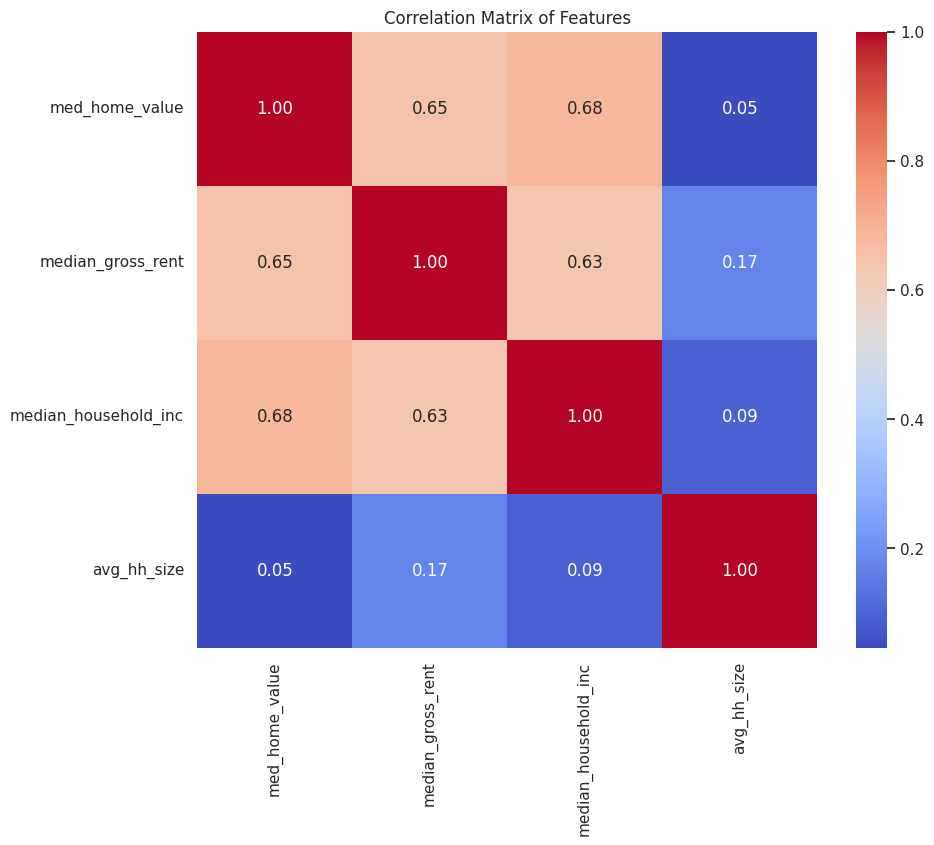

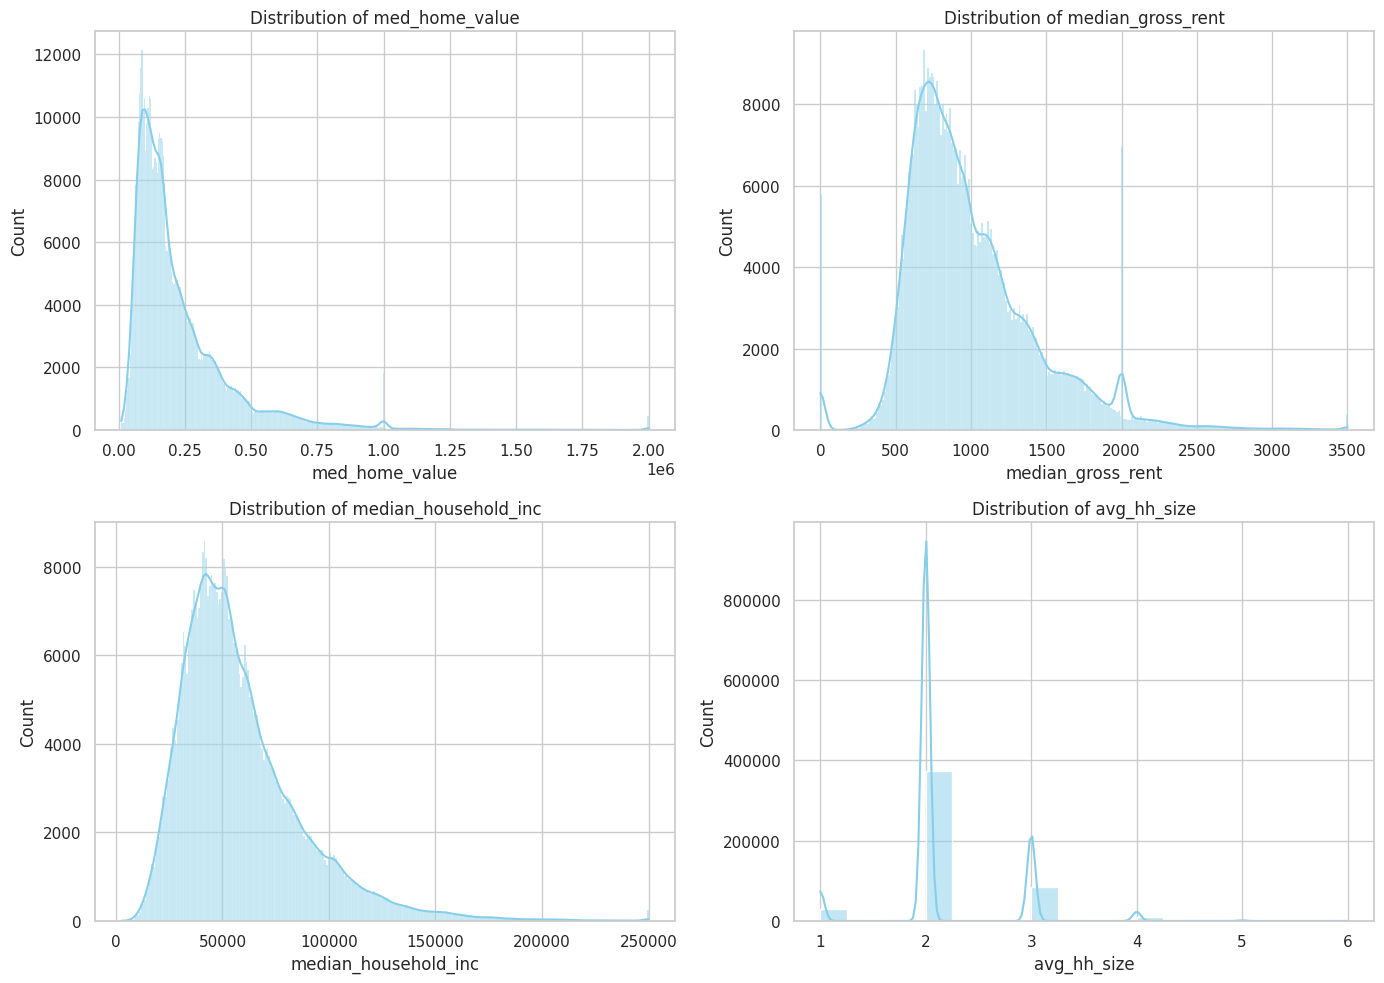

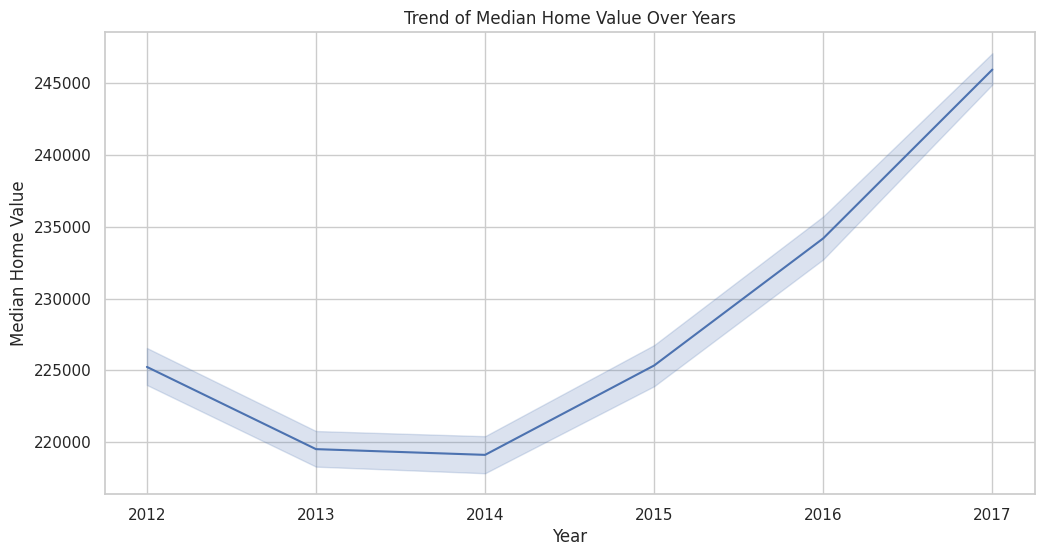

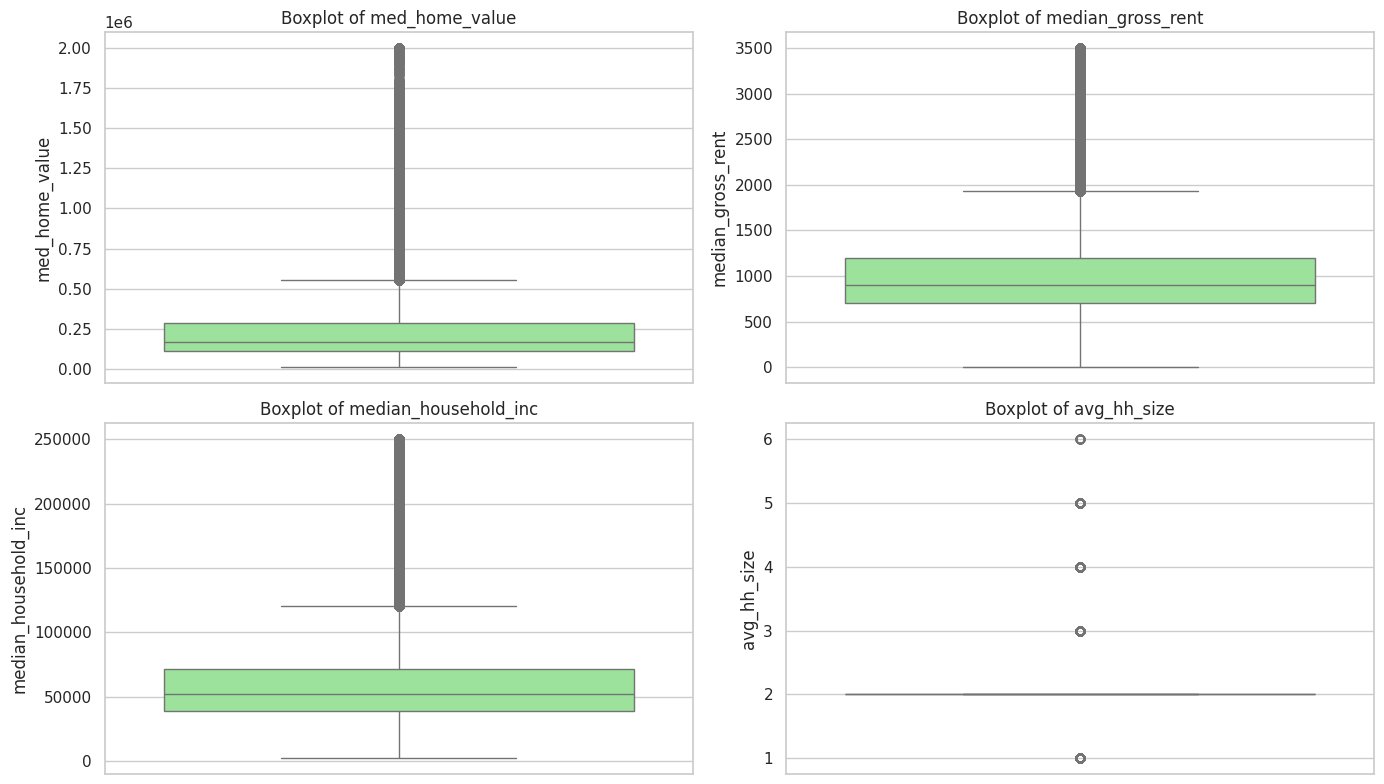

In [16]:
# **3. Exploratory Data Analysis (EDA)**
# Distribution Plots for Key Features
key_features = ['med_home_value', 'median_gross_rent', 'median_household_inc', 'avg_hh_size']

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[key_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


plt.figure(figsize=(14, 10))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Trend Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='med_home_value', estimator='mean')
plt.title('Trend of Median Home Value Over Years')
plt.xlabel('Year')
plt.ylabel('Median Home Value')
plt.show()

# Boxplots to Check for Outliers
plt.figure(figsize=(14, 8))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[feature], color='lightgreen')
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


In [18]:
# **4. Data Aggregation**

agg_dict = {
    'id': 'count',
    'tract_num': 'nunique',
    'sample_count': 'sum',
    'avg_hh_size': 'mean',
    'med_home_value': 'mean',
    'median_household_inc': 'mean',
    'median_gross_rent': 'mean',
    'state_label_encoded': 'first'
}

# Aggregate by ZIP code and year
df_zip_year = df.groupby(['zip_code', 'year']).agg(agg_dict).reset_index()

# Create target variable
df_zip_year['target'] = df_zip_year.groupby('zip_code')['med_home_value'].shift(-1)
df_zip_year.dropna(subset=['target'], inplace=True)

In [19]:
# **5. Split Data into Train and Test Sets**

train_data = df_zip_year[df_zip_year['year'] <= 2015]
test_data = df_zip_year[df_zip_year['year'] == 2016]

features = ['med_home_value', 'median_gross_rent', 'median_household_inc', 'avg_hh_size', 'state_label_encoded']
target_col = 'target'

# Feature Scaling
scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])

y_train = target_scaler.fit_transform(train_data[target_col].values.reshape(-1, 1)).ravel()
y_test = target_scaler.transform(test_data[target_col].values.reshape(-1, 1)).ravel()

In [20]:
# **6. Model Training with Bayesian Optimization**

from sklearn.ensemble import RandomForestRegressor

# Define objective function for Bayesian Optimization
def model_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': max(min(max_features, 1.0), 0.1),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse}, R²: {r2}')
    return -rmse

# Hyperparameter search space
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (0.1, 1.0)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Train final model
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate model
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Optimized Random Forest Test RMSE:", rmse)
print("R² Score:", r2)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
RMSE: 273830.4194440723, R²: -56548067328.18453
| 1         | -2.738e+0 | 9.367     | 0.9556    | 7.588     | 6.789     | 240.4     |
RMSE: 248163.1938917729, R²: -46443947232.856384
| 2         | -2.482e+0 | 5.652     | 0.1523    | 8.796     | 6.809     | 737.3     |
RMSE: 260527.9748157114, R²: -51187404660.4325
| 3         | -2.605e+0 | 3.35      | 0.9729    | 8.492     | 3.699     | 263.6     |
RMSE: 252648.6100212251, R²: -48138018513.55591
| 4         | -2.526e+0 | 6.118     | 0.3738    | 5.723     | 5.456     | 362.1     |
RMSE: 265398.3073734021, R²: -53119096630.14843
| 5         | -2.654e+0 | 13.4      | 0.2255    | 3.629     | 4.931     | 510.5     |
RMSE: 274038.7229030558, R²: -56634132552.52555
| 6         | -2.74e+05 | 14.33     | 0.9694    | 7.849     | 9.606     | 732.3     |
RMSE: 266971.80539473495

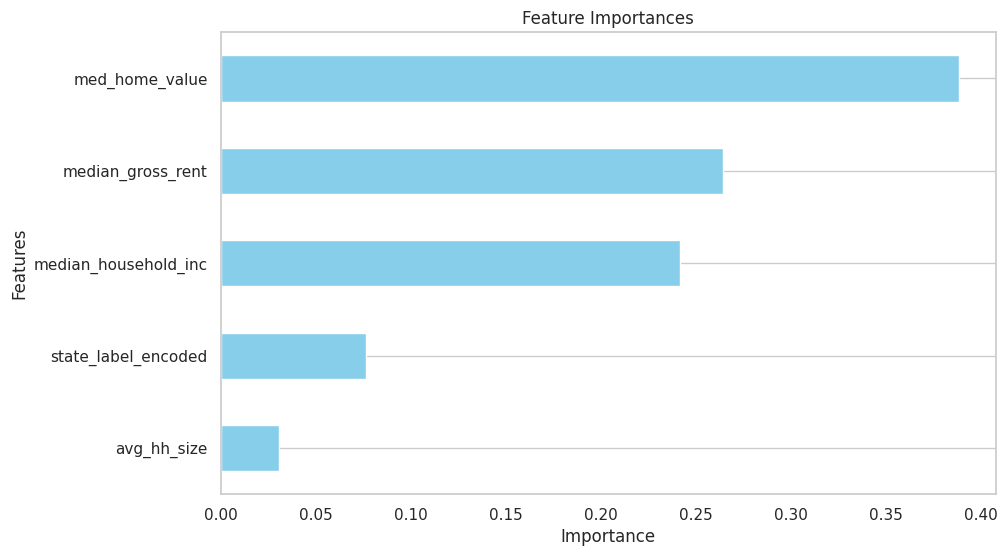

In [21]:
# **7. Feature Importance Visualization**

plt.figure(figsize=(10, 6))
importances = pd.Series(best_rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title="Feature Importances", color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

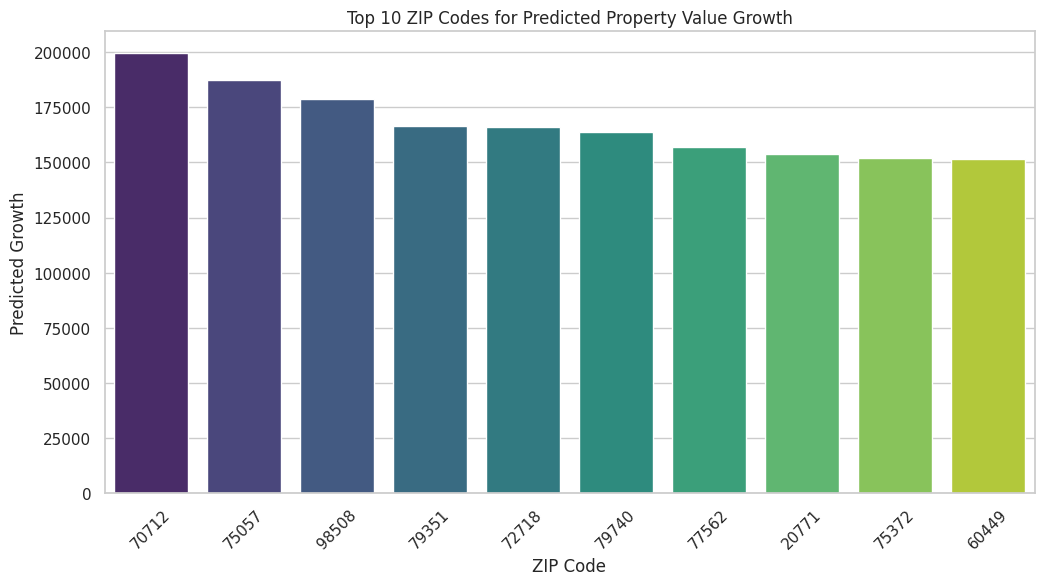


***** TOP 10 ZIP CODES FOR PROPERTY INVESTMENT *****
       zip_code  current_value  predicted_value  predicted_growth
93622     70712        21700.0    221094.835781     199394.835781
99356     75057        21500.0    208731.256951     187231.256951
128955    98508        23000.0    201709.784506     178709.784506
107069    79351       103800.0    270191.445998     166391.445998
96387     72718       257500.0    423762.631257     166262.631257
107524    79740        49800.0    213527.134492     163727.134492
104104    77562       115300.0    272254.394045     156954.394045
25163     20771       151800.0    305396.674431     153596.674431
100063    75372       109200.0    261075.908041     151875.908041
81811     60449       147500.0    299137.210643     151637.210643


In [22]:
# **8. Rank ZIP Codes by Predicted Growth**

test_data['predicted_value'] = y_pred
test_data['current_value'] = test_data['med_home_value']
test_data['predicted_growth'] = test_data['predicted_value'] - test_data['current_value']

# Top 10 ZIP codes
ranked = test_data.sort_values('predicted_growth', ascending=False)
top_10 = ranked.head(10)

# Visualization for Predicted Growth
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='zip_code', y='predicted_growth', palette='viridis')
plt.title('Top 10 ZIP Codes for Predicted Property Value Growth')
plt.xlabel('ZIP Code')
plt.ylabel('Predicted Growth')
plt.xticks(rotation=45)
plt.show()

print("\n***** TOP 10 ZIP CODES FOR PROPERTY INVESTMENT *****")
print(top_10[['zip_code', 'current_value', 'predicted_value', 'predicted_growth']])

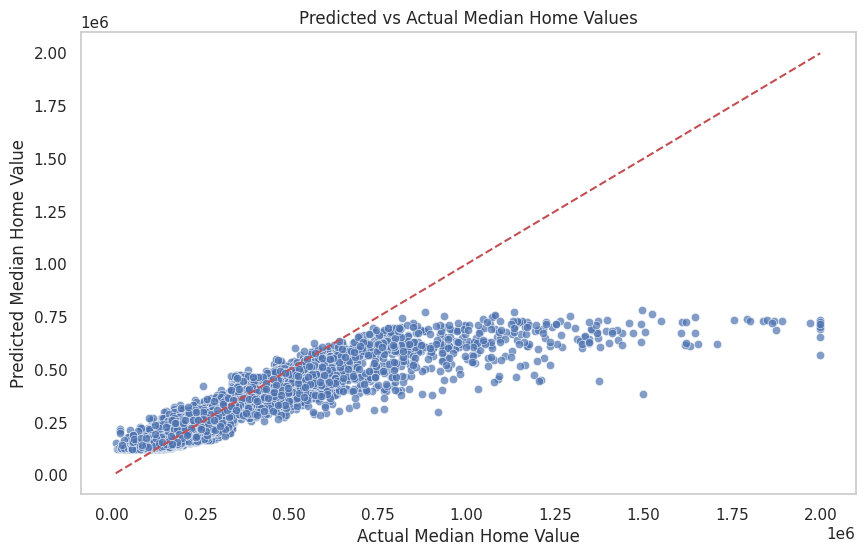

In [23]:
# **9. Predicted vs Actual Plot**

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['current_value'], y=test_data['predicted_value'], alpha=0.7)
plt.plot([test_data['current_value'].min(), test_data['current_value'].max()],
         [test_data['current_value'].min(), test_data['current_value'].max()],
         'r--')
plt.title('Predicted vs Actual Median Home Values')
plt.xlabel('Actual Median Home Value')
plt.ylabel('Predicted Median Home Value')
plt.grid()
plt.show()

In [34]:
pip install -U esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00


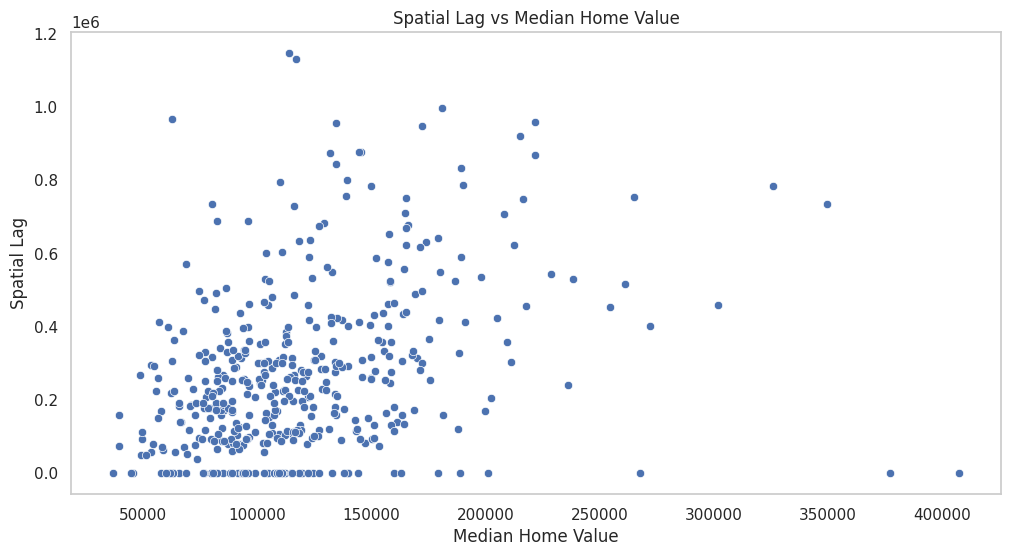

In [31]:
# **10. Spatial Dependency Analysis**

try:
    # Load shapefile
    shapefile_path = '/content/tl_2024_us_zcta520.shp'
    zip_shapes = gpd.read_file(shapefile_path)
    zip_shapes['zip_code'] = zip_shapes['ZCTA5CE20'].astype(str)

    # Merge with test data
    gdf = pd.merge(test_data, zip_shapes, on='zip_code', how='left')
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
    gdf = gdf.dropna(subset=['geometry'])

    # Build spatial weight matrix
    w = libpysal.weights.Queen.from_dataframe(gdf)
    gdf['spatial_lag'] = libpysal.weights.spatial_lag.lag_spatial(w, gdf['med_home_value'])

    # Visualize spatial lag effect
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=gdf['med_home_value'], y=gdf['spatial_lag'])
    plt.title('Spatial Lag vs Median Home Value')
    plt.xlabel('Median Home Value')
    plt.ylabel('Spatial Lag')
    plt.grid()
    plt.show()

except Exception as e:
    print("Spatial analysis skipped due to missing shapefile or dependency issue:", e)

<Figure size 1400x800 with 0 Axes>

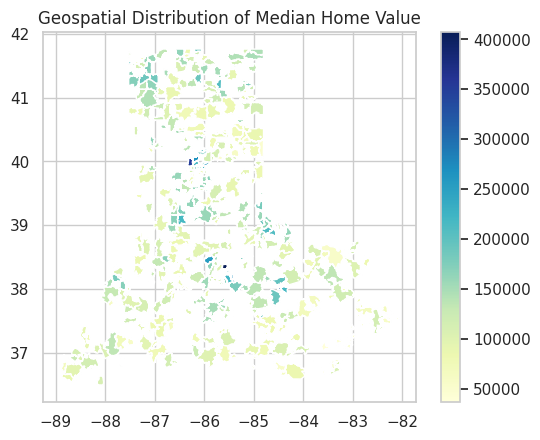

<Figure size 1400x800 with 0 Axes>

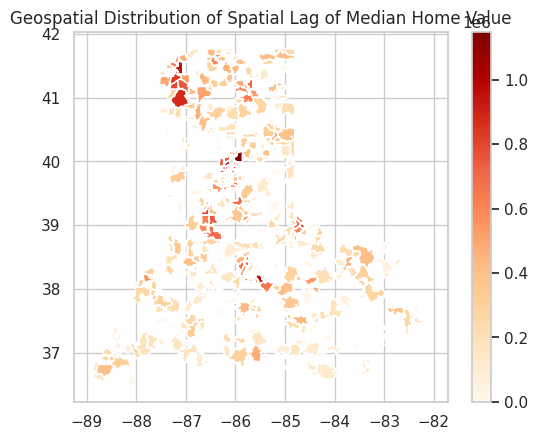

In [36]:
try:
    # Map of Median Home Value
    plt.figure(figsize=(14, 8))
    gdf.plot(column='med_home_value', cmap='YlGnBu', legend=True)
    plt.title('Geospatial Distribution of Median Home Value')
    plt.show()

    # Map of Spatial Lag
    plt.figure(figsize=(14, 8))
    gdf.plot(column='spatial_lag', cmap='OrRd', legend=True)
    plt.title('Geospatial Distribution of Spatial Lag of Median Home Value')
    plt.show()

except Exception as e:
    print("Geospatial Visualization skipped due to missing data or dependencies:", e)

<Figure size 1400x800 with 0 Axes>

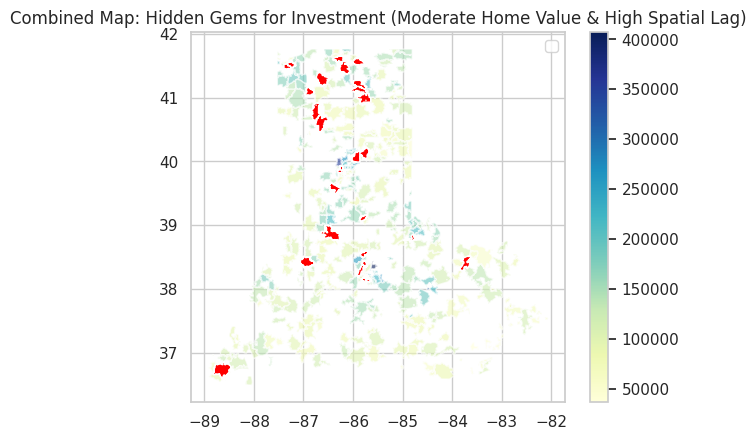

Hidden Gem ZIP Codes: ['40213' '40214' '40217' '40219' '40505' '41041' '41095' '42066' '46011'
 '46060' '46158' '46208' '46225' '46228' '46254' '46268' '46342' '46410'
 '46506' '46510' '46526' '46534' '46580' '46614' '46923' '46962' '47126'
 '47150' '47172' '47232' '47421' '47546' '47957' '47960']


In [38]:
try:
    # Define criteria for hidden gems: moderate home value & high spatial lag
    moderate_value = (gdf['med_home_value'] > gdf['med_home_value'].quantile(0.3)) & (gdf['med_home_value'] < gdf['med_home_value'].quantile(0.7))
    high_spatial_lag = gdf['spatial_lag'] > gdf['spatial_lag'].quantile(0.75)

    # Highlight hidden gems
    gdf['hidden_gem'] = moderate_value & high_spatial_lag

    # Combined Map
    plt.figure(figsize=(14, 8))
    base = gdf.plot(column='med_home_value', cmap='YlGnBu', legend=True, alpha=0.6)
    gdf[gdf['hidden_gem']].plot(ax=base, color='red', markersize=50, marker='o', label='Hidden Gems')

    plt.title('Combined Map: Hidden Gems for Investment (Moderate Home Value & High Spatial Lag)')
    plt.legend()
    plt.show()

    # Extract ZIP codes of hidden gems
    hidden_gem_zip_codes = gdf[gdf['hidden_gem']]['zip_code'].unique()
    print("Hidden Gem ZIP Codes:", hidden_gem_zip_codes)

except Exception as e:
    print("Combined Geospatial Visualization skipped due to missing data or dependencies:", e)